**Haystack: Question Answering**


There are two types of question answering system, Abstractive & Extractive:

**Abstractive** means the model understands the embeddings of the text & using similarity measure compares the texts with each-other. The answer having vectors similar to a certain text in the context would be the answer. This sort of creates the answer to the question throught the context. 

**Extractive** means the model literally picks up the matching text present in the context using again a similarity measure but extracts the literal answer to the question.

In this notebook, there are two types of document stores utilised: ElasticsearchDocumentStore & FAISSDocumentStore

**ElasticsearchDocumentStore** is a sort of database for the system, where we can store the context and simultaneously use it in our system. Elastic search is like a no sql database.

**FAISSDocumentStore** uses sql database for storing the documents of our system. Like the above different search method we can make use of this method in the same way.






**Haystack-Pipeline:**

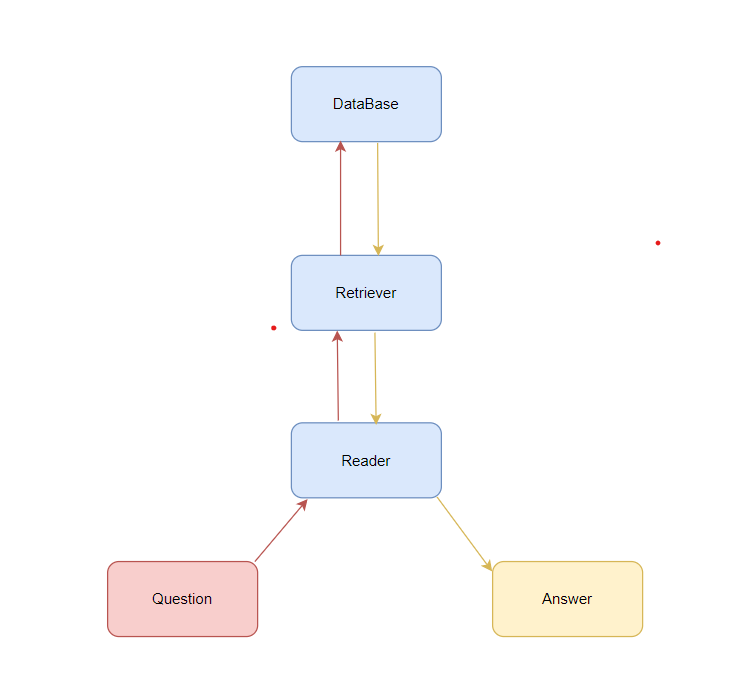

###Extractive-QA Pipeline

In [ ]:
!nvidia-smi

Thu Feb 24 12:45:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install farm-haystack

     |████████████████████████████████| 430 kB 7.6 MB/s 
     |████████████████████████████████| 10.9 MB 81.5 MB/s 
     |████████████████████████████████| 219 kB 47.0 MB/s 
     |████████████████████████████████| 321 kB 55.2 MB/s 
     |████████████████████████████████| 359 kB 92.4 MB/s 
     |████████████████████████████████| 981 kB 76.2 MB/s 
     |████████████████████████████████| 50 kB 9.8 MB/s 
     |████████████████████████████████| 14.1 MB 89.6 MB/s 
     |████████████████████████████████| 5.6 MB 80.4 MB/s 
     |████████████████████████████████| 79 kB 10.3 MB/s 
     |████████████████████████████████| 43 kB 2.9 MB/s 
     |████████████████████████████████| 3.3 MB 58.0 MB/s 
     |████████████████████████████████| 10.7 MB 30.0 MB/s 
     |████████████████████████████████| 178 kB 107.7 MB/s 
     |████████████████████████████████| 85 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 71.0 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |██████████████

In [ ]:
!pip install --upgrade pip
!pip install git+https://github.com/deepset-ai/haystack.git

  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-_ms3weoi/farm-haystack_27ebb6a8d31d48cab93308b686edffbe
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-install-_ms3weoi/farm-haystack_27ebb6a8d31d48cab93308b686edffbe
  Resolved https://github.com/deepset-ai/haystack.git to commit 15c70bdb9f8cd16511d1eb9ed9b2e9466de65cbf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from haystack.utils import clean_wiki_text, convert_files_to_dicts, fetch_archive_from_http, print_answers
from haystack.nodes import FARMReader, TransformersReader

In [ ]:
from haystack.utils import launch_es
launch_es()

WARNING - haystack.utils.doc_store -  Tried to start Elasticsearch through Docker but this failed. It is likely that there is already an existing Elasticsearch instance running. 


In [ ]:
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

import os
from subprocess import Popen, PIPE, STDOUT

es_server = Popen(
    ["elasticsearch-7.9.2/bin/elasticsearch"], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1)
)
! sleep 30

In [ ]:
from haystack.document_stores import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")

In [ ]:
doc_dir = "data/article_txt_got"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

INFO - haystack.utils.import_utils -  Found data stored in `data/article_txt_got`. Delete this first if you really want to fetch new data.


False

In [ ]:
dicts = convert_files_to_dicts(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)
document_store.write_documents(dicts)

In [ ]:
print(dicts[:3])

[{'content': '"\'\'\'Home\'\'\'" is the second episode of the sixth season of HBO\'s fantasy television series \'\'Game of Thrones\'\', and the 52nd overall. The episode was written by Dave Hill and directed by Jeremy Podeswa.\nThe Wildlings arrive at Castle Black and force Alliser Thorne and his allies to surrender, allowing Melisandre to resurrect Jon Snow. Ramsay Bolton seizes Winterfell and the North for himself; Tyrion Lannister unchains the dragons being held in the catacombs of Meereen; Arya Stark proceeds to the next step in her training; and Bran Stark sees the past.\n"Home" received high praise from critics, citing the return of Jon Snow, the reintroduction of Bran Stark with the Three-eyed Raven, and the unexpected death of Roose Bolton, as high points in the episode. Filming of the episode\'s closing scene, the director took inspiration from \'\'The Anatomy Lesson\'\'. In the United States, the episode premiere achieved a viewership of 7.29 million in its initial broadcast.

In [ ]:
from haystack.nodes import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=document_store)

Hugging Face's model hub (https://huggingface.co/models)

In [ ]:
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/roberta-base-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/roberta-base-squad2
INFO - haystack.modeling.logger -  ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 3 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0    0    0 
INFO - haystack.modeling.infer -  /w\  /w\  /w\
INFO - haystack.modeling.infer -  /'\  / \  /'\


In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever)

In [ ]:
prediction = pipe.run(
    query="Who is the father of Arya Stark?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)

Inferencing Samples:   0%|          | 0/1 [00:00<?, ? Batches/s]/usr/local/lib/python3.7/dist-packages/haystack/modeling/model/prediction_head.py:485: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 37.67 Batches/s]


In [ ]:
from pprint import pprint
pprint(prediction)

{'answers': [<Answer {'answer': 'Eddard', 'type': 'extractive', 'score': 0.9919579923152924, 'context': "s Nymeria after a legendary warrior queen. She travels with her father, Eddard, to King's Landing when he is made Hand of the King. Before she leaves,", 'offsets_in_document': [{'start': 147, 'end': 153}], 'offsets_in_context': [{'start': 72, 'end': 78}], 'document_id': 'ba2a8e87ddd95e380bec55983ee7d55f', 'meta': {'name': '43_Arya_Stark.txt'}}>,
             <Answer {'answer': 'Ned', 'type': 'extractive', 'score': 0.9767242968082428, 'context': "\n====Season 1====\nArya accompanies her father Ned and her sister Sansa to King's Landing. Before their departure, Arya's half-brother Jon Snow gifts A", 'offsets_in_document': [{'start': 46, 'end': 49}], 'offsets_in_context': [{'start': 46, 'end': 49}], 'document_id': '180c2a6b36369712b361a80842e79356', 'meta': {'name': '43_Arya_Stark.txt'}}>,
             <Answer {'answer': 'Lord Eddard Stark', 'type': 'extractive', 'score': 0.89304018020

We have fired a query requesting best answers for the question from the **Database**.

In [ ]:
print_answers(prediction, details="minimum")


Query: Who is the father of Arya Stark?
Answers:
[   {   'answer': 'Eddard',
        'context': 's Nymeria after a legendary warrior queen. She travels '
                   "with her father, Eddard, to King's Landing when he is made "
                   'Hand of the King. Before she leaves,'},
    {   'answer': 'Ned',
        'context': '\n'
                   '====Season 1====\n'
                   'Arya accompanies her father Ned and her sister Sansa to '
                   "King's Landing. Before their departure, Arya's "
                   'half-brother Jon Snow gifts A'},
    {   'answer': 'Lord Eddard Stark',
        'context': 'ark daughters.\n'
                   'During the Tourney of the Hand to honour her father Lord '
                   'Eddard Stark, Sansa Stark is enchanted by the knights '
                   'performing in the event.'},
    {   'answer': 'Joffrey',
        'context': 'laying with one of his wooden toys.\n'
                   "After Eddard discovers the 

##Creating our own Context & Feeding it into the Pipeline.

In [ ]:
dicts = [{
    'content': "Sundar Pichar was born in Madurai, India, Pichai earned his degree from IIT Kharagpur in metallurgical engineering. Moving to the United States, he attained an M.S. from Stanford University in materials science and engineering and further attained an MBA from the Wharton School of the University of Pennsylvania, where he was named a Siebel Scholar and a Palmer Scholar, respectively. Pichai began his career as a materials engineer. Following a short stint at the management consulting firm McKinsey & Co., Pichai joined Google in 2004, where he led the product management and innovation efforts for a suite of Google's client software products, including Google Chrome and Chrome OS, as well as being largely responsible for Google Drive. ",
    'meta': {'name': "Sundar Pichai"}
}]

In [ ]:
document_store.write_documents(dicts)

In [ ]:
pipe = ExtractiveQAPipeline(reader, retriever)

In [ ]:
prediction = pipe.run(
    query="where was Sundar Pichai born?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)

Inferencing Samples:   0%|          | 0/1 [00:00<?, ? Batches/s]/usr/local/lib/python3.7/dist-packages/haystack/modeling/model/prediction_head.py:485: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 63.29 Batches/s]


In [ ]:
print_answers(prediction, details="minimum")


Query: where was Sundar Pichai born?
Answers:
[   {   'answer': 'Madurai, India',
        'context': 'Born in Madurai, India Pichai earned his degree from IIT '
                   'Kharagpur in metallurgical engineering. Moving to the '
                   'United States, he attained an M.S. from'},
    {   'answer': 'Cooper Village',
        'context': 'Suzy, Caroline, and David) and grew up in Manhattan, first '
                   'in Peter Cooper Village, then on 86th Street where he '
                   'spent most of his childhood, before e'},
    {   'answer': '== House Arryn  ==\n'
                  'House Arryn is one of the Great Houses of the Seven '
                  'Kingdoms and is the principal house in the Vale',
        'context': '\n'
                   '== House Arryn  ==\n'
                   'House Arryn is one of the Great Houses of the Seven '
                   'Kingdoms and is the principal house in the Vale. It is '
                   'descended from Kings of'}

# Abstractive QA-Pipeline

In [ ]:
!pip install grpcio-tools==1.34.1
!pip install git+https://github.com/deepset-ai/haystack.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.6 MB/s eta 0:00:00
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-7fuwxczb
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-7fuwxczb
  Resolved https://github.com/deepset-ai/haystack.git to commit 15c70bdb9f8cd16511d1eb9ed9b2e9466de65cbf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from haystack.document_stores import FAISSDocumentStore
document_store = FAISSDocumentStore(faiss_index_factory_str="Flat", return_embedding=True)

INFO - haystack.modeling.model.optimization -  apex not found, won't use it. See https://nvidia.github.io/apex/


In [ ]:
from haystack.utils import convert_files_to_dicts, fetch_archive_from_http, clean_wiki_text
from haystack.nodes import Seq2SeqGenerator

In [ ]:
doc_dir = "data/article_txt_got"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)
dicts = convert_files_to_dicts(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)

In [ ]:
from haystack.nodes import RAGenerator, DensePassageRetriever

In [ ]:
retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    use_gpu=True,
    embed_title=True,
)


generator = RAGenerator(
    model_name_or_path="facebook/rag-token-nq",
    use_gpu=True,
    top_k=1,
    max_length=200,
    min_length=2,
    embed_title=True,
    num_beams=2,
)

INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find facebook/dpr-question_encoder-single-nq-base locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded facebook/dpr-question_encoder-single-nq-base


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find facebook/dpr-ctx_encoder-single-nq-base locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded facebook/dpr-ctx_encoder-single-nq-base
INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1


Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/bart/configuration_bart.py:178: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  f"Please make sure the config includes `forced_bos_token_id={self.bos_token_id}` in future versions. "


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizerFast'.


Downloading:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

Some weights of RagTokenForGeneration were not initialized from the model checkpoint at facebook/rag-token-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
document_store.delete_documents()
document_store.write_documents(dicts)
document_store.update_embeddings(retriever=retriever)

Writing Documents:   0%|          | 0/2497 [00:00<?, ?it/s]

INFO - haystack.document_stores.faiss -  Updating embeddings for 2357 docs...


Updating Embedding:   0%|          | 0/2357 [00:00<?, ? docs/s]

Create embeddings:   0%|          | 0/2368 [00:00<?, ? Docs/s]

In [ ]:
QUESTIONS = [
    "who is Arya Stark?",
    "Why did Arya Stark's character get portrayed in a television adaptation?",
    "What kind of character does Arya Stark play?"
]

In [ ]:
from haystack.pipelines import GenerativeQAPipeline
from haystack.utils import print_answers

pipe = GenerativeQAPipeline(generator=generator, retriever=retriever)
for question in QUESTIONS:
    res = pipe.run(query=question, params={"Generator": {"top_k": 1}, "Retriever": {"top_k": 5}})
    print_answers(res, details="minimum")

/usr/local/lib/python3.7/dist-packages/transformers/models/rag/tokenization_rag.py:97: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1749: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  UserWarning,



Query: who is Arya Stark?
Answers:
[{'answer': ' maisie williams'}]

Query: Why did Arya Stark's character get portrayed in a television adaptation?
Answers:
[{'answer': ' resemblance to wolves'}]

Query: What kind of character does Arya Stark play?
Answers:
[{'answer': ' maisie williams'}]
